In [1]:
#RNN识别垃圾邮件
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.models import Model
from keras.layers import LSTM,Activation,Dense,Dropout,Input,Embedding
from keras.optimizers import RMSprop
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping #提前终止训练过程
%matplotlib inline

Using TensorFlow backend.


In [2]:
df = pd.read_csv('SMSSpamCollection.csv',delimiter='\t',encoding='latin-1')
df.head()

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [3]:
#df.drop(['Unnamed:2','Unnamed:3','Unnamed:4'],axis=1,inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
v1    5572 non-null object
v2    5572 non-null object
dtypes: object(2)
memory usage: 87.2+ KB


Text(0.5, 1.0, 'Number of ham and spam messages')

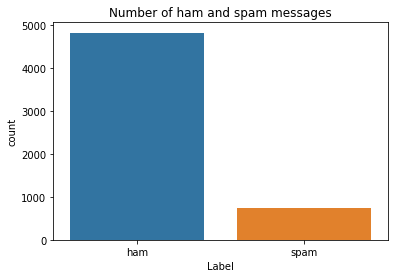

In [4]:
sns.countplot(df.v1)
plt.xlabel('Label')
plt.title('Number of ham and spam messages')

In [5]:
X = df.v2
Y = df.v1
le = LabelEncoder()
Y = le.fit_transform(Y)
Y = Y.reshape(-1,1)
Y

array([[0],
       [0],
       [1],
       ...,
       [0],
       [0],
       [0]])

In [6]:
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.15)

In [22]:
max_words = 1000 #最多使用1000单词
max_len = 150 #短信单词长度，酌情填充
tok = Tokenizer(num_words=max_words) #句子拆单词
tok.fit_on_texts(X_train)
sequences = tok.texts_to_sequences(X_train)
sequences_matrix = sequence.pad_sequences(sequences,maxlen=max_len) #句子截断

In [8]:
def RNN():
    inputs = Input(shape=[max_len])
    layer = Embedding(max_words,50,input_length=max_len)(inputs)
    layer = LSTM(64)(layer)
    layer = Dense(256)(layer)
    layer = Activation('relu')(layer)
    layer = Dropout(0.5)(layer)
    layer = Dense(1)(layer)
    layer = Activation('sigmoid')(layer)
    model = Model(inputs=inputs,outputs=layer)
    return model

In [9]:
model = RNN()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 150, 50)           50000     
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                29440     
_________________________________________________________________
dense_1 (Dense)              (None, 256)               16640     
_________________________________________________________________
activation_1 (Activation)    (None, 256)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 257       
__________

In [10]:
model.compile(loss='binary_crossentropy',optimizer=RMSprop(),metrics=['accuracy'])#编译网络模型

In [11]:
model.fit(sequences_matrix,Y_train,batch_size=128,epochs=10,validation_split=0.2,callbacks=[EarlyStopping(monitor='val_loss',min_delta=0.0001)])

Train on 3788 samples, validate on 948 samples
Epoch 1/10
3788/3788 [==============================] - 3s 900us/step - loss: 0.3105 - acc: 0.8844 - val_loss: 0.1476 - val_acc: 0.9599
Epoch 2/10
3788/3788 [==============================] - 2s 654us/step - loss: 0.0811 - acc: 0.9786 - val_loss: 0.0730 - val_acc: 0.9778
Epoch 3/10
3788/3788 [==============================] - 2s 659us/step - loss: 0.0459 - acc: 0.9871 - val_loss: 0.0601 - val_acc: 0.9821
Epoch 4/10
3788/3788 [==============================] - 3s 662us/step - loss: 0.0324 - acc: 0.9918 - val_loss: 0.0674 - val_acc: 0.9831


In [12]:
test_sequences = tok.texts_to_sequences(X_test)
test_sequences = sequence.pad_sequences(test_sequences,maxlen=max_len)
accr = model.evaluate(test_sequences,Y_test)

836/836 [==============================] - 0s 260us/step


In [13]:
print('Test set\n Loss:{:0.3f}\n Accuracy:{:0.3f}'.format(accr[0],accr[1]))

Test set
 Loss:0.044
 Accuracy:0.989


In [14]:
text = "hi,call me back when you have time"
seq = tok.texts_to_sequences([text])
seq_matrix = sequence.pad_sequences(seq,maxlen=max_len)
pred = model.predict(seq_matrix)
pred

array([[0.00164658]], dtype=float32)